<a href="https://colab.research.google.com/github/PayalSahrma/Course/blob/master/CompputerVision_UNet_Lung_Seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lung segmentation from thoracic X-Ray images with UNET

*by Georgios K. Ouzounis*

## Contents

1. [The challenge](#the-challenge)
2. [Get the training data](#get-the-training-data)
3. [Get the code repo](#get-the-code-repo)
4. [Create the model](#create-the-model)
5. [Train the model](#train-the-model)
6. [Inference on test images](#inference-on-test-images)
7. [Acknowledgements](#acknowledgements)

## The challenge <a name="the-challenge"></a>

<img src="https://raw.githubusercontent.com/georgiosouzounis/lung-seg-xray-unet/main/images/title2.png" width = "600"/>

Given an annotated image data set of lungs from thoracic x-ray images, train a semantic segmentation model (UNET) and compute inference on new, previously unseen images.

**DISCLAIMER:**
In the following notebook, "author" refers to Georgios Ouzounis.

- The work presented in this notebook is independent of the past works of the author at various companies and institutions. This is different in terms of the technology and code used and does not relate to any prior products, research work, or IP developed by the author.
- This notebook (code) is developed explicitly for educational purposes, demonstrating how one can train the UNET model. It is not meant for any other usage and the author cannot be held accountable for its outcome and deliverables if used for a purpose other than the one stated.   

**IMPORTANT:** before you start working on this notebook, change your Runtime setting to GPU.

## Get the training data <a name="get-the-training-data"></a>

For this exercise, we will use a publicly available dataset of thoracic X-Ray images. It is posted in [kaggle.com](https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels) and is a kind contribution by [Nikhil Pandey](https://www.kaggle.com/nikhilpandey360). The archived collection is approximately 9.58 GB in size.

Note that the runtime must be changed to “GPU” for the purpose of this demonstration.

### Connect to Kaggle.com

We will import this data set into our working session directly from Kaggle. To read  more on how to import Kaggle data sets directly into Google Colab, please refer to this [documentation page](https://www.kaggle.com/general/74235).

In [ ]:
# The following command will give you access to the Kaggle APIs from the Google Colab environment
#Install the kaggle API package

!pip install -q kaggle

In [ ]:
# create a configuration directory named .kaggle in the root directory
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Download the kaggle.json file from "API Token" section of your Kaggle profile. The detailed steps for this process were covered in the previous module.

Once you have the kaggle.json file handy with you, **right-click** on the side bar in the **left side of the colab screen** and select **Upload File**. As soon as you do this, it will ask you to choose your kaggle.json token file from your local storage.

Once the upload is done successfully, the kaggle.json file should be visible in the left-side bar. If it is not visible, try to refresh.

In [ ]:
# move the kaggle.json token file into the root .kaggle directory
!mv /content/kaggle.json ~/.kaggle/

In [ ]:
# change the permissions of the file. Here, chmod 600 means that only the owner of the file has full read and write access to it.
#Once a file permission is set to 600, no one else can access the file.

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Let's test the kaggle API we installed
 #The following command will show a list of the data sets available

!kaggle datasets list

ref                                                                 title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                                     DAIGT V2 Train Dataset                       29MB  2023-11-16 01:38:36           1936        190  1.0              
muhammadbinimran/housing-price-prediction-data                      Housing Price Prediction Data               763KB  2023-11-21 17:56:32           8622        152  1.0              
everydaycodings/produce-prices-dataset                              Fruits and Vegetables Prices Dataset        232KB  2023-12-11 13:40:33           1319         25  1.0              
thedevastator/books-sales-and-ratings                               Books Sales 

###  Get the dataset

In [ ]:
# download the relevant data set for thoracic X-Ray from Kaggle
# To start the download, use the following command

!kaggle datasets download 'nikhilpandey360/chest-xray-masks-and-labels'

This exercise will take approximately 4 min to complete

### Setup the project data directories

Let’s now create our data set directory structure. You will be using this directory to store images and their corresponding masks. The data set directory structure will look like this:

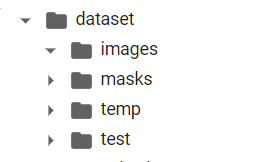

In [ ]:
%mkdir dataset
%mkdir dataset/images # this directory will store the source images
%mkdir dataset/masks # this directory will store the annotation masks
%mkdir dataset/test # this directory will store the test images
%mkdir dataset/temp # this directory will act as the temp storage

### Uncompress the archive

You might get a warning message about the storage usage, which you may ignore because the data set will fit into the available space

In [ ]:
#The following command will uncompress the zipped data set you downloaded earlier in the folder location /dataset/tmp
!unzip chest-xray-masks-and-labels.zip -d dataset/temp/

the above takes approximately 5 min to complete

In [ ]:
# Once you have extracted the required information from the chest-xray-masks-and-labels.zip file,
# remove the original zip file to clear some memory space
%rm chest-xray-masks-and-labels.zip

In [ ]:
#You un-compressed the downloaded Kaggle data set in /dataset/tmp folder.
#Let's take a look at the files in the data set you downloaded earlier.

%ls dataset/temp/Lung\ Segmentation

ClinicalReadings/  masks/                       NLM-MontgomeryCXRSet-ReadMe.pdf
CXR_png/           NLM-ChinaCXRSet-ReadMe.docx  test/


In [ ]:
#Now we will move all the images to dataset/images directory
%mv dataset/temp/Lung\ Segmentation/CXR_png/* dataset/images/
IMAGE_PATH = "/content/dataset/images/"

In [ ]:
#Now we will move all the mask files to dataset/masks directory
%mv dataset/temp/Lung\ Segmentation/masks/* dataset/masks/
MASK_PATH = '/content/dataset/masks/'

In [ ]:
#Now we will move all the test image files to dataset/test directory
%mv dataset/temp/Lung\ Segmentation/test/* dataset/test/
TEST_PATH = '/content/dataset/test/'

In [ ]:
# We have placed all the required image files in their corresponding folders. There is no need for the dataset/temp folder now.
# Let's delete the folder to clear some space

%rm -r dataset/temp/

| <img src="https://raw.githubusercontent.com/georgiosouzounis/lung-seg-xray-unet/main/images/image1.png" width="300"/> | <img src="https://raw.githubusercontent.com/georgiosouzounis/lung-seg-xray-unet/main/images/mask1.png" width="300"/> |
|:--:|:--:|
|example of an x-ray image | example of the corresponding annotation|

### Harmonize the dataset

Next, we will make several corrections to bring the contents of the ```images/``` and ```masks/``` directories in agreement with the UNET library requirements. This will ensure that the model building process is smooth.


**Step 1:** some of the masks contain the ```_mask``` suffix in their file-name. Example: There is a file named "CHNCXR_0005_0.png" in the images folder, and its corresponding mask file currently is named "CHNCXR_0005_0_mask.png" is masks folder.

 Every image in the ```images/``` directory must have a mask in the ```masks/``` directory of exactly the same name. Thus, we need to crop this suffix wherever it appears.

In [ ]:
#let's create a function to chop off the suffix _mask from all the file names() in the dataset/masks folder
# importing os module
import os

# this suffix cropping function will take filename 's' and if
# 1. 's' contains suffix '_mask', then the function will chop off the suffix and return the updated file name
# 2. 's' does not contains the suffix '_mask', then the function will simply return the same file name

def rchop(s, suffix):
    if suffix and s.endswith(suffix):
        return s[:-len(suffix)]
    return s

suffix = "_mask.png"

# iterate over all mask images and edit the file names wherever the _mask suffix is present
for count, filename in enumerate(os.listdir("/content/dataset/masks")):
  src = "/content/dataset/masks/" + filename
  res = rchop(src, suffix)
  dst = ""
  if src != res:
    dst = rchop(src, suffix) + ".png"
    os.rename(src, dst)

**Step 2:** Not all source images have corresponding mask images. We need to identify those that do not have them and remove them (place them in the temp directory)

In [ ]:
# check the number of files in the images/ and masks/ directories to ensure that all the image files have their corresponding
# mask files. If numbers are not matching, then it ,means that some of the images do not have mask files

import os.path

print("number of files in images/ directory: " + str(len([name for name in os.listdir("/content/dataset/images/")])))
print("number of files in masks/ directory: " + str(len([name for name in os.listdir("/content/dataset/masks/")])))

In [ ]:
# function to confirm the existence of a particular file in a given directory

def searchFile(fileName, TARGET_PATH):
  for root, dirs, files in os.walk(TARGET_PATH):

  #check for all the files’ TARGET_PATH to determine if a particular file (called "fileName") is present or not

    for Files in files:
      #print(Files)
      found = Files.find(fileName)

  #stop the search as soon as you find the file in TARGET_PATH

      if found != -1:
        break
  return found

In [ ]:
#Create a directory for storing all orphan image files. Orphan files are the image files whose corresponding
# mask files are missing, and so, we will discard these files

%mkdir /content/dataset/orphan_images

In [ ]:
# clean up the images/ directory by removing all the images that do not have a mask
import shutil

cnt = 0

#iterate over all the images name in /dataset/images folder
for count, filename in enumerate(os.listdir("/content/dataset/images")):

#check if a particular file name present in the /dataset/image directory is also present in /dataset/mask directory

  found = searchFile(filename, MASK_PATH)

#if the file name is present in the dataset/image directory and is not present in the /dataset/mask directory, it means that the image is of no use.
# All such images will be moved to the /dataset/orphan_images folder

  if found == -1:
    cnt = cnt + 1
    src = "/content/dataset/images/" + filename
    dst = "/content/dataset/orphan_images/" + filename
    dest = shutil.move(src, dst)
print("number of files not matched: " + str(cnt))

number of files not matched: 96


In [ ]:
# After all the orphan files are moved to a separate folder /dataset/orphan_images, check the consistency once again
#we will again check the length of images and masks folder

print("number of files in images/ directory: " + str(len([name for name in os.listdir("/content/dataset/images/")])))
print("number of files in masks/ directory: " + str(len([name for name in os.listdir("/content/dataset/masks/")])))

**Step 3:** convert mask images into binary. If there are multiple classes, you need to set a unique pixel value for each class and reformat the mask images accordingly. In this case, we have one class only (lungs); thus, each image must be binary; 0 for background and 1 for lungs.

In [ ]:
import cv2

#iterate over all images in the /dataset/masks directory

for count, filename in enumerate(os.listdir("/content/dataset/masks")):
  src = "/content/dataset/masks/" + filename

#convert the masks images into binary images and store them in the same folder location [name of the file will still remain the same]
  img = cv2.imread(src, cv2.IMREAD_GRAYSCALE)
  (T, res) = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY)
  cv2.imwrite(src, res)

the above takes approximately 60 sec to execute

## Get the code repo <a name="get-the-code-repo"></a>

The code repo is an edited version of Divan Gupta's [Image-Segmentation-Keras](https://github.com/divamgupta/image-segmentation-keras), to support Keras in TF2.5.

In [ ]:
#Clone the code repo from github
!git clone https://github.com/georgiosouzounis/semantic-segmentation-tf2.git

Cloning into 'semantic-segmentation-tf2'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 36 (delta 2), reused 32 (delta 2), pack-reused 0
Unpacking objects: 100% (36/36), done.


In [ ]:
#Go to /semantic-segmentation-tf2 directory
%cd semantic-segmentation-tf2/

/content/semantic-segmentation-tf2


## Create the model <a name="create-the-model"></a>

Before we create the model, let us first find a reasonable set of dimensions to resize our input images to.

In [ ]:
# Let's check the image attributes for a particular image file in the /content/dataet folder

import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread("/content/dataset/test/CHNCXR_0194_0.png")
img.shape

(2992, 2991, 3)

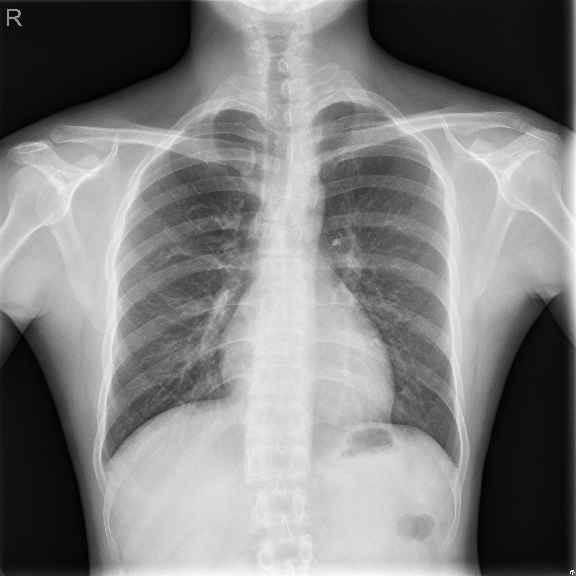

In [ ]:
#After running previous command, you can clearly see that the image size is quite large (2992X2991), and it would be tough to fit such large images in toour network
#So, let's resize the image to the dimension (576,576)

img = cv2.resize(img, (576, 576))
cv2_imshow(img)

In [ ]:
# import the vgg_unet model
# VGG16 is the base model for vgg_unet model

from tf2_sem_seg.models.unet import vgg_unet

In [ ]:
# instantiate our model for transfer learning:
# + n_classes = 1 (background) + 1 (lungs)
# + input_height: resized the number of rows for the input image; it must be divisible by 32
# + input_width:  resized the number of cols for the input image; it must be divisible by 32

model = vgg_unet(n_classes=2, input_height=576, input_width=576)

58889256/58889256 [==============================] - 4s 0us/step


Let us now review the model we just instantiated and compare it against the u-net and vgg16 architectures.

| <img src="https://github.com/georgiosouzounis/lung-seg-xray-unet/raw/main/images/unet.png" width="500"/> | <img src="https://github.com/georgiosouzounis/lung-seg-xray-unet/raw/main/images/vgg16.png" width="500"/> |
|:---:|:---:|
|the u-net architecture | the vgg16 architecture |

In [ ]:
#The summary is textual and includes information about:

#The layers and their order in the model
#The output shape of each layer
#The number of parameters (weights) in each layer
#The total number of parameters (weights) in the model
#The summary can be created by calling the summary() function on the model that returns a string that in turn can be printed.


# print the summary of the model
print(model.summary())

In [ ]:
# review the model architecture
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Train the model <a name="train-the-model"></a>

In [ ]:
# create a temporary directory for model checkpoints
%mkdir /content/tmp/

In [ ]:

# train_images: This is the directory containing the source images for training
# train_annotations: This is the directory containing the masks for training
# checkpoints_path: This is the directory for storing weights and logs
# epochs: the number of training epochs is set to 5 for the demo
#   Increase this to a higher number for better results.

model.train(
    train_images =  "../dataset/images/",
    train_annotations = "../dataset/masks/",
    checkpoints_path = "../tmp/vgg_unet_1" , epochs=5
)

In [ ]:
# create a back-up in your Google Drive

%cp /content/tmp/* /content/drive/MyDrive/deep-learning/lung-seg-xray/


cp: target '/content/drive/MyDrive/deep-learning/lung-seg-xray/' is not a directory


## Inference on test images <a name="inference-on-test-images"></a>

In [ ]:
#Load the pretrained model to make a segmentation prediction on the given image


out = model.predict_segmentation(
    inp="/content/dataset/test/CHNCXR_0025_0.png",
    out_fname="/content/tmp/out.png"
)

1/1 [==============================] - 3s 3s/step


In [ ]:
# the cv2.imread() method loads an image from the specified file
#If the image cannot be read (because of a missing file, improper permissions, unsupported or invalid format), then this method returns an empty matrix.
#You can use the resize function to scale the images
# It helps in reducing the number of pixels from an image, which offers several advantages, e.g., It can reduce the time required for training of a neural network

img = cv2.imread("/content/tmp/out.png")
img = cv2.resize(img, (int(img.shape[1]/5), int(img.shape[0]/5)))
cv2_imshow(img)

In [ ]:
#Load the pretrained model to make a segmentation prediction on the given image
# alpha-blend the inference with the source

o = model.predict_segmentation(
    inp="/content/dataset/test/CHNCXR_0025_0.png",
    out_fname="/content/tmp/out_blend.png" , overlay_img=True, show_legends=True,
    class_names = ["background","lungs"]
)

1/1 [==============================] - 0s 23ms/step


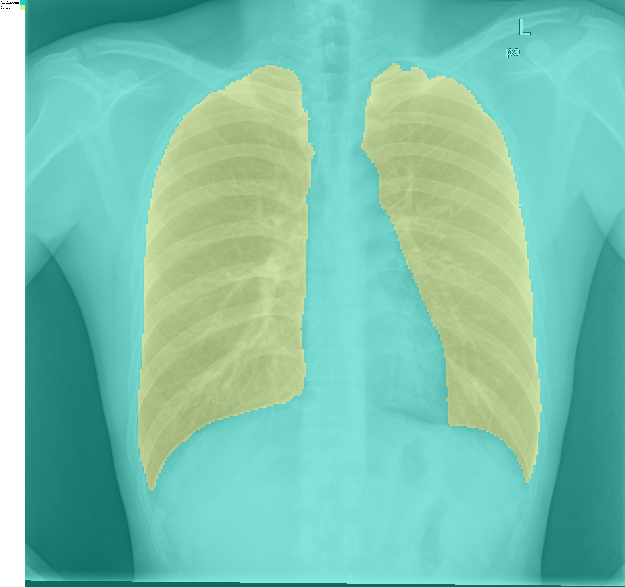

In [ ]:
#Read the image and resize it
img = cv2.imread("/content/tmp/out_blend.png")
img = cv2.resize(img, (int(img.shape[1]/5), int(img.shape[0]/5)))
from google.colab.patches import cv2_imshow
cv2_imshow(img)

## Acknowledgements <a name="acknowledgements"></a>

The author would like to thank and acknowledge the following:

- [Divan Gupta](https://github.com/divamgupta) and all other contributors to the ```Image Segmentation Keras : Implementation of Segnet, FCN, UNet, PSPNet and other models in Keras``` [repo](https://github.com/divamgupta/image-segmentation-keras) for their amazing work in putting all the functionality together to make semantic segmentation accessible through Keras.
- [Nikhil Pandey](https://www.kaggle.com/nikhilpandey360) for posting an excellent quality X-Ray dataset of thoracic scans in Kaggle.  